In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from lettuce.boundary import EquilibriumBoundaryPU, EquilibriumOutletP, AntiBounceBackOutlet
from lettuce.observables import Observable
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
import torch
import time
import datetime
import os

In [8]:
### OUTPUT SETTINGS - do you want parameters, observables, plots, timeseres and/or vtk/vti-files? change the booleans below...
# IMPORTANT: set correct output_path, for example "/home/YourUserName/simulation_output"
output_path = "."

# name: if you want something specific in the dir-name
name = "cylinder2D_example_test"

# data: .txt with timestamp, parameters and observable-values (mean coefficient of drag, max. coefficient of lift, Strouhal-Number) and plots
# ...will be saved in [output_path]/data_[timestamp]_[name]/
output_data = True

# vtk/vti: save vtk
# ...will be saved in [output_path]/data_[timestamp]_[name]/vtk/
output_vtk = True
vtk_fps=10  #frames per second_PU

In [5]:
### SIMULATION PARAMETERS (and estimation of timesteps needed to reach T_target)
re = 200   # Reynoldsnumber
Ma = 0.05     # Machnumber
n_steps = 140000    # number of steps
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

# relative startingpoint for drag-measurement (make sure periodic state is reached)
periodic_start = 0.9  # relative start of peak_finding for Cd_mean Measurement to cut of any transients

# GEOMETRY
gridpoints_per_diameter = 20  # gp_per_D = GPD -> this defines the resolution ( D_LU = GPD+1)
domain_width_in_D = 10  # D/Y = DpY = diameters per domain width in Y-direction -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2 * domain_width_in_D  # D/X (domain length in X- / flow-direction

# RELATION [GPD to DpY] check
# if DpY is even, resulting GPD can't be odd for symmetrical cylinder and channel
# ...if DpY is even, GPD will be corrected to even GPD for symmetrical cylinder
# ...use odd DpY to use odd GPD
gpd_correction=False
if domain_width_in_D % 2 == 0 and gridpoints_per_diameter % 2 != 0:
    gpd_correction = True   # gpd_was_corrected-flag
    gpd_setup = gridpoints_per_diameter   # store old gpd for output
    gridpoints_per_diameter = int(gridpoints_per_diameter/2)*2   # make gpd even
    print("(!) domain_width_in_D is even, gridpoints_per_diameter will be "+str(gridpoints_per_diameter)+". Use odd domain_width_in_D to enable use of odd GPD!")

# SIMULATOR settings
u_init = 1    # initial velocity field: # 0: uniform u=0, # 1: uniform u=1, # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # perturb initial symmetry by small sine-wave in initial velocity field -> triggers Karman-vortex street for Re > 46
bb_wall = False    # lateral walls: True= bounce-back-walls parabolic velocity inlet, False= periodic BC and uniform velocity inlet
cylinder = True    # obstacle: True = cylinder, False = no obstacle

# T_PU to n_steps estimation: (for example for Re=200 the periodic state is reached for T_PU > 140
T_target=200
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/(gridpoints_per_diameter+1))*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round(((gridpoints_per_diameter+1)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round(((gridpoints_per_diameter+1)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")


mlups_2060super = 20
mlups_2080ti = 30   # 40 for GPD30,DpY19,nsteps=150000 (steigend mit der Auflösung)

if output_vtk:
    print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/(gridpoints_per_diameter+1))*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**2*domain_length_in_D*domain_width_in_D
print("No. of gridpoints:", gridpoints)

shape_LU: 400 x 200
T with 140000 steps: 192.45 seconds
n_steps to simulate 1 second: 727.46 steps
n_steps to simulate 200 seconds: 145492.0 steps
generates approx. 1925 .vti/.vtk-frames
No. of gridpoints: 80000


In [9]:
### (no user input) CREATE OUTPUT DIRECTORIES
if output_data:  # toggle output

    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    dir_name = "/data_" + str(timestamp) + "_" + name
    os.makedirs(output_path+dir_name)

    if output_vtk:
        vtk_path = output_path+dir_name+"/vtk/out"
        print("vtk_path: " + vtk_path)
    print("dir_name: "+dir_name)
else:
    output_vtk = False

vtk_path: ./data_230612_152731_cylinder2D_example_test/vtk/out
dir_name: /data_230612_152731_cylinder2D_example_test


In [10]:
### NEW FULLWAY BOUNCE BACK BOUNDARY CONDITION (with force calculation)
class FullwayBounceBackBoundary:
    """Fullway Bounce-Back Boundary (with added force_on_boundary calculation)
    - fullway = inverts populations within two substeps
    - call() must be called after Streaming substep
    - calculates the force on the boundary:
        - calculation is done after streaming, but theoretically the force is evaluated based on the populations touching/crossing the boundary IN this streaming step
    """
    # based on Master-Branch "class BounceBackBoundary"
    # added option to calculate force on the boundary by Momentum Exchange Method

    def __init__(self, mask, lattice):
        self.mask = lattice.convert_to_tensor(mask)  # which nodes are solid
        self.lattice = lattice
        self.force_sum = torch.zeros_like(self.lattice.convert_to_tensor(self.lattice.stencil.e[0]))  # summed force vector on all boundary nodes, in D dimensions (x,y,(z))
        ### create f_mask, needed for force-calculation
        # ...(marks all fs which streamed into the boundary in prior streaming step)
        if self.lattice.D == 2:
            nx, ny = mask.shape  # domain size in x and y
            self.f_mask = np.zeros((self.lattice.Q, nx, ny), dtype=bool)
                # f_mask: [q, nx, ny], marks all fs on the boundary-border, which point into the boundary/solid
            self.force = np.zeros((nx, ny, 2))  # force in x and y on all individual nodes
            a, b = np.where(mask)
                # np.arrays: list of (a) x-coordinates and (b) y-coordinates in the boundary.mask
                # ...to enable iteration over all boundary/wall/object-nodes
            for p in range(0, len(a)):  # for all TRUE-nodes in boundary.mask
                for i in range(0, self.lattice.Q):  # for all stencil-directions c_i (lattice.stencil.e in lettuce)
                    try:  # try in case the neighboring cell does not exist (= an f pointing out of the simulation domain)
                        if not mask[a[p] + self.lattice.stencil.e[i, 0], b[p] + self.lattice.stencil.e[i, 1]]:
                            # if the neighbour of p is False in the boundary.mask, p is a solid node, neighbouring a fluid node:
                            # ...the direction pointing from the fluid neighbour to solid p is marked on the solid p
                            self.f_mask[self.lattice.stencil.opposite[i], a[p], b[p]] = 1
                    except IndexError:
                        pass  # just ignore this iteration since there is no neighbor there
        if self.lattice.D == 3:  # like 2D, but in 3D...guess what...
            nx, ny, nz = mask.shape
            self.f_mask = np.zeros((self.lattice.Q, nx, ny, nz), dtype=bool)
            self.force = np.zeros((nx, ny, nz, 3))
            a, b, c = np.where(mask)
            for p in range(0, len(a)):
                for i in range(0, self.lattice.Q):
                    try:  # try in case the neighboring cell does not exist (an f pointing out of simulation domain)
                        if not mask[a[p] + self.lattice.stencil.e[i, 0], b[p] + self.lattice.stencil.e[i, 1], c[p] + self.lattice.stencil.e[i, 2]]:
                            self.f_mask[self.lattice.stencil.opposite[i], a[p], b[p], c[p]] = 1
                    except IndexError:
                        pass  # just ignore this iteration since there is no neighbor there
        self.f_mask = self.lattice.convert_to_tensor(self.f_mask)

    def __call__(self, f):
        # FULLWAY-BBBC: inverts populations on all boundary nodes

        # calc force on boundary:
        self.calc_force_on_boundary(f)

        # bounce (invert populations on boundary nodes)
        f = torch.where(self.mask, f[self.lattice.stencil.opposite], f)
        return f

    def make_no_collision_mask(self, f_shape):
        assert self.mask.shape == f_shape[1:]
        return self.mask

    def calc_force_on_boundary(self, f):
        # calculate force on boundary by momentum exchange method (MEA, MEM) according to Kruger et al., 2017, pp.215-217:
            # momentum (f_i*c_i - f_i_opposite*c_i_opposite = 2*f_i*c_i for a resting boundary) is summed for all...
            # ...populations pointing at the surface of the boundary
        tmp = torch.where(self.f_mask, f, torch.zeros_like(f))  # all populations f in the fluid region, which point at the boundary
        self.force_sum = 2 * torch.einsum('i..., id -> d', tmp, self.lattice.e)  # CALCULATE FORCE / v2.0 - M.Bille: dx_lu = dt_lu is allways 1 (!)
            # explanation for 2D:
                # sums forces in x and in y (and z) direction,
                # tmp: all f, that are marked in f_mask
                    # tmp.size: 9 x nx x ny (for 2D)
                # self.lattice.e: 9 x 2 (for 2D)
                # - the multiplication of f_i and c_i is down through the first dimension (q) = direction, indexname i
                # - the sign is given by the coordinates of the stencil-vectors (e[0 to 8] for 2D)
                # -> results in twodimensional output (index d) for x- and y-direction (for 2D)
                # "dx**self-lattice.D" = dx³ (3D) or dx² (2D) as prefactor, converting momentum density to momentum
                    # theoretically DELTA P (difference in momentum density) is calculated
                    # assuming smooth momentum transfer over dt, force can be calculated through: F= dP/dt
                    # ...that's why theoretically dividing by dt=dx=1 is necessary (BUT: c_i=1=dx/dt=1 so that can be omitted (v2.0) !)

        # calculate Force on all boundary nodes individually:
        if self.lattice.D == 2:
            self.force = 2 * torch.einsum('qxy, qd -> xyd', tmp, self.lattice.e)  # force = [x-coordinate, y-coodrinate, direction (0=x, 1=y)]
        if self.lattice.D == 3:
            self.force = 2 * torch.einsum('qxyz, qd -> xyzd', tmp, self.lattice.e)  # force = [x-coordinate, y-coodrinate, z-coodrinate, direction (0=x, 1=y, 2=z)]

In [11]:
### NEW OBSERVABLES Coefficient of Drag and Lift (relying on force calculation (see above)

class DragCoefficient(Observable):
    """The drag coefficient of an obstacle, calculated using momentum exchange method (MEM, MEA) according to a
    modified version of M.Kliemank's Drag Coefficient Code

    calculates the density, gets the force in x direction on the obstacle boundary,
    calculates the coefficient of drag
    """

    def __init__(self, lattice, flow, obstacle_boundary, area):
        super().__init__(lattice, flow)
        self.obstacle_boundary = obstacle_boundary
        self.area_lu = area * (self.flow.units.characteristic_length_lu/self.flow.units.characteristic_length_pu) ** (self.lattice.D-1) # crosssectional area of obstacle i LU (! lengthdimension in 2D -> area-dimension = self.lattice.D-1)

    def __call__(self, f):
        #rho = torch.mean(self.lattice.rho(f[:, 0, ...]))  # simple rho_mean, including the boundary region
        # rho_mean (excluding boundary region):
        rho_tmp = torch.where(self.lattice.convert_to_tensor(self.flow.solid_mask), self.lattice.convert_to_tensor(torch.nan), self.lattice.rho(f))
        rho = torch.nanmean(rho_tmp)
        force_x_lu = self.obstacle_boundary.force_sum[0]  # get current force on obstacle in x direction
        drag_coefficient = force_x_lu / (0.5 * rho * self.flow.units.characteristic_velocity_lu ** 2 * self.area_lu)  # calculate drag_coefficient in LU
        return drag_coefficient

class LiftCoefficient(Observable):
    """The lift coefficient of an obstacle, calculated using momentum exchange method (MEM, MEA) according to a
        modified version of M.Kliemank's lift Coefficient Code

        calculates the density, gets the force in y direction on the obstacle boundary,
        calculates the coefficient of lift
        """

    def __init__(self, lattice, flow, obstacle_boundary, area):
        super().__init__(lattice, flow)
        self.obstacle_boundary = obstacle_boundary
        self.area_lu = area * (self.flow.units.characteristic_length_lu / self.flow.units.characteristic_length_pu) ** (
                    self.lattice.D - 1)

    def __call__(self, f):
        #rho = torch.mean(self.lattice.rho(f[:, 0, ...]))  # simple rho_mean, including the boundary region
        # rho_mean (excluding boundary region):
        rho_tmp = torch.where(self.lattice.convert_to_tensor(self.flow.solid_mask), self.lattice.convert_to_tensor(torch.nan), self.lattice.rho(f))
        rho = torch.nanmean(rho_tmp)
        force_y_lu = self.obstacle_boundary.force_sum[1] # get current force on obstacle in y direction
        lift_coefficient = force_y_lu / (0.5 * rho * self.flow.units.characteristic_velocity_lu ** 2 * self.area_lu)  # calculate lift_coefficient in LU
        return lift_coefficient

In [12]:
### FLOW Class for 2D-cylinder-obstacle-flow
# ...Halfway Bounce Back Boundary is not working with current lettuce (commented out)

class Cylinder2D:
    """
        (!) refined version of flow/obstacle.py (so far only for 2D obstacles)
        Flow class to simulate the flow around an object (obstacle_mask).
        It consists of one inflow (equilibrium boundary)
        and one outflow (anti-bounce-back-boundary), leading to a flow in positive x direction.

        Parameters (selection)
        ----------
        lateral_walls: True = channel flow with parabolic velocity inlet, False = periodic lateral boundaries and uniform velocity inlet
        hwbb: True = use halfway bounce back boundary, False = use fullway bounce back boundary
        perturb_init: True = slight perturbation in the initial condition to trigger vKarman vortex street in symmetrical systems (for Re>46)
        u_init: initial velocity profile: 0 = uniform u=0, 1 = uniform u=u_char, 2 = parabolic (poiseuille like)

        Attributes (selection)
        ----------
        obstacle_mask : np.array with dtype = np.bool
            Boolean mask to define the obstacle. The shape of this object is the shape of the grid.
            Initially set to zero (no obstacle).

    """

    def __init__(self, reynolds_number, mach_number, lattice,
                 char_length_pu, char_length_lu, char_velocity_pu=1, y_lu=5, x_lu=10,
                 lateral_walls=True,
                 #hwbb=True,
                 perturb_init=True,
                 u_init=0):
        self.shape = (int(x_lu), int(y_lu))  # shape of the domain in LU
        self.char_length_pu = char_length_pu  # characteristic length
        self.x_lu = x_lu  # domain length
        self.y_lu = y_lu  # domain width

        self.perturb_init = perturb_init  # toggle: introduce asymmetry in initial solution
        self.u_init = u_init  # toggle: initial solution velocity profile
        self.lateral_walls = lateral_walls  # toggle: lateral walls or lateral periodic boundary
        #self.hwbb = hwbb  # toggle: bounce back algorithm: halfway or fullway

        self.units = UnitConversion(
            lattice,
            reynolds_number=reynolds_number,
            mach_number=mach_number,
            characteristic_length_lu=char_length_lu,
            characteristic_length_pu=char_length_pu,
            characteristic_velocity_pu=char_velocity_pu  ### reminder: u_char_lu = Ma * cs_lu = Ma * 1/sqrt(3)
        )

        self.solid_mask = np.zeros(shape=self.shape, dtype=bool)  # marks all solid nodes (obstacle, walls, ...)
        self.in_mask = np.zeros(self.grid[0].shape, dtype=bool)  # marks all inlet nodes
        self.in_mask[0, 1:-1] = True  # inlet on the left
        self.wall_mask = np.zeros_like(self.solid_mask)  # marks lateral walls
        if self.lateral_walls:
            self.wall_mask[:, [0, -1]] = True
            self.solid_mask[np.where(self.wall_mask)] = 1
        self._obstacle_mask = np.zeros_like(self.solid_mask)  # marks all obstacle nodes (for fluid-solid-force_calc.)

        # generate parabolic velocity profile for inlet BC if lateral_walls=True (== channel-flow)
        self.u_inlet = self.units.characteristic_velocity_pu * self._unit_vector()
        if self.lateral_walls:
            ## parabolic velocity profile, zeroing on the edges
            ## How to parabola:
            ## 1.parabola in factoriezed form (GER: "Nullstellenform"): y = (x-x1)*(x-x2)
            ## 2.parabola with a maximum and zero at x1=0 und x2=x0: y=-x*(x-x0)
            ## 3.scale parabola, to make y_s(x_s)=1 the maximum: y=-x*(x-x0)*(1/(x0/2)²)
            ## (4. optional) scale amplitude with 1.5 to have a mean velocity of 1, also making the integral of a homogeneous velocity profile with u=1 and the parabolic profile being equal
            ny = self.shape[1]  # number of gridpoints in y direction
            ux_temp = np.zeros((1, ny))  # variable for x-velocities on inlet boundary
            y_coordinates = np.linspace(0, ny, ny)  # linspace() creates n points between 0 and ny, including 0 and ny:
                # top and bottom velocity values will be zero to agree with wall-boundary-condition
            ux_temp[:, 1:-1] = - np.array(self.u_inlet).max() * y_coordinates[1:-1] * (y_coordinates[1:-1] - ny) * 1 / (ny / 2) ** 2  # paraboplic velocity profile
            # scale with 1.5 to achieve a mean velocity of u_char!
            # in 2D u1 needs Dimension 1 x ny (!)
            uy_temp = np.zeros_like(ux_temp)  # y-velocities = 0
            self.u_inlet = np.stack([ux_temp, uy_temp], axis=0)  # stack/pack u-field

    @property
    def obstacle_mask(self):
        return self._obstacle_mask

    @obstacle_mask.setter
    def obstacle_mask(self, m):
        assert isinstance(m, np.ndarray) and m.shape == self.shape
        self._obstacle_mask = m.astype(bool)
        self.solid_mask[np.where(self._obstacle_mask)] = 1  # (!) this line is not doing what it should! solid_mask is now defined in the initial solution (see below)!

    def initial_solution(self, x):
        p = np.zeros_like(x[0], dtype=float)[None, ...]
        u_max_lu = self.units.characteristic_velocity_lu * self._unit_vector()
        u_max_lu = append_axes(u_max_lu, self.units.lattice.D)
        self.solid_mask[np.where(self.obstacle_mask)] = 1  # This line is needed, because the obstacle_mask.setter does not define the solid_mask properly (see above)
        ### initial velocity field: "u_init"-parameter
        # 0: uniform u=0
        # 1: uniform u=1
        # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
        u = (1 - self.solid_mask) * u_max_lu
        if self.u_init == 1:
            # initiale velocity u=1 on every fluid node
            u = (1 - self.solid_mask) * u_max_lu
        elif self.u_init == 2:  # parabolic along y, uniform along x (similar to poiseuille-flow)
            ny = self.shape[1]  # number of gridpoints in y direction
            ux_factor = np.zeros(ny)  # vector for one column (u(x=0))
            # multiply parabolic profile with every column of the velocity field:
            y_coordinates = np.linspace(0, ny, ny)
            ux_factor[1:-1] = - y_coordinates[1:-1] * (y_coordinates[1:-1] - ny) * 1 / (ny / 2) ** 2
            u = np.einsum('k,ijk->ijk', ux_factor, u)
        else:
            u = u*0  # uniform u=0

        ### perturb initial velocity field-symmetry to trigger 'von Karman' vortex street
        # perturb_init = True/False
        if self.perturb_init:
            # overlays a sine-wave on the second column of nodes
            ny = x[1].shape[1]
            if u.max() < 0.5 * self.units.characteristic_velocity_lu:
                # add perturbation for small velocities
                u[0][1] += np.sin(np.arange(0, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_lu * 1.0
            else:
                # multiply scaled down perturbation
                u[0][1] *= 1 + np.sin(np.arange(0, ny) / ny * 2 * np.pi) * 0.3
        return p, u

    @property
    def grid(self):
        xyz = tuple(self.units.convert_length_to_pu(np.linspace(0,n,n)) for n in self.shape)  # tuple of lists of x,y,(z)-values/indices
        return np.meshgrid(*xyz, indexing='ij')  # meshgrid of x-, y- (und z-)values/indices

    @property
    def boundaries(self):
        # inlet ("left side", x[0],y[1:-1])
        inlet_boundary = EquilibriumBoundaryPU(
                                            self.in_mask,
                                            self.units.lattice, self.units,
                                            #self.units.characteristic_velocity_pu * self._unit_vector())
                                            self.u_inlet) # works with a 1 x D vector or an ny x D vector thanks to einsum-magic in EquilibriumBoundaryPU
        # lateral walls ("top and bottom walls", x[:], y[0,-1])
        lateral_boundary = None
        if self.lateral_walls:
            # if self.hwbb:  # use halfway bounce back
            #     lateral_boundary = HalfwayBounceBackBoundary(self.wall_mask, self.units.lattice)
            # else:  # else use fullway bounce back
            #     lateral_boundary = FullwayBounceBackBoundary(self.wall_mask, self.units.lattice)
            lateral_boundary = FullwayBounceBackBoundary(self.wall_mask, self.units.lattice)
        # outlet ("right side", x[-1],y[:])
        outlet_boundary = EquilibriumOutletP(self.units.lattice, [1, 0])  # outlet in positive x-direction
        # obstacle (for example: obstacle "cylinder" with radius centered at position x_pos, y_pos) -> to be set via obstacle_mask.setter
        obstacle_boundary = None
        # (!) the obstacle_boundary should alway be the last boundary in the list of boundaries to correctly calculate forces on the obstacle
        # if self.hwbb:
        #     obstacle_boundary = HalfwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)
        # else:
        #     obstacle_boundary = FullwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)
        obstacle_boundary = FullwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)
        if lateral_boundary is None:  # if lateral boundary is periodic...don't return a boundary-object
            return [
                inlet_boundary,
                outlet_boundary,
                obstacle_boundary
                ]
        else:
            return [
                inlet_boundary,
                outlet_boundary,
                lateral_boundary,
                obstacle_boundary
                ]

    def _unit_vector(self, i=0):
        return np.eye(self.units.lattice.D)[i]


In [13]:
### SIMULATOR SETUP

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64, native=False)  # for "new lettuce"
# lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)  #for "old lettuce"
    # stencil, device, dtype

flow = Cylinder2D(reynolds_number=re, mach_number=Ma,
                   lattice=lattice,
                   char_length_pu=setup_diameter,
                   char_length_lu=gridpoints_per_diameter+1,
                   char_velocity_pu=flow_velocity,
                   y_lu=domain_width_in_D*gridpoints_per_diameter,
                   x_lu=domain_length_in_D*gridpoints_per_diameter,
                   lateral_walls=bb_wall,
                   #hwbb=halfway, # not working in most recent lettuce
                   perturb_init=perturb_init,
                   u_init=u_init
                  )

# define a Cylinder-Obstacle
radius_LU = 0.5 * gridpoints_per_diameter
y_pos_LU = 0.5 * gridpoints_per_diameter * domain_width_in_D + 0.5
x_pos_LU = y_pos_LU

index_list = tuple(np.linspace(1,n,n) for n in flow.shape)  # Tupel indexd lists (1-n (non zero-based!))
xLU, yLU = np.meshgrid(*index_list, indexing='ij')  # meshgrid of x-, y- (and z-)indizes/indexs?/indexes?! - this is simulation, not grammar...

condition = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU
flow.obstacle_mask[np.where(condition)] = 1


### simulation object (simulator)
tau = flow.units.relaxation_parameter_lu
sim = lt.Simulation(flow, lattice,
                     lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau),
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, CollisionOperator-Object(Parameter), Streaming-Object

### Reporter

# VTK Reporter -> Visualization
if output_vtk:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)

# Observable reporter: drag coefficient
DragObservable = DragCoefficient(lattice,flow,flow.boundaries[-1],area=setup_diameter)  # ! area A=2*r is in PU and 1-dimensional in 2D
Dragreport = lt.ObservableReporter(DragObservable, out=None)
sim.reporters.append(Dragreport)

# Observable reporter: lift coefficient
LiftObservable = LiftCoefficient(lattice,flow,flow.boundaries[-1],area=setup_diameter)
Liftreport = lt.ObservableReporter(LiftObservable, out=None)
sim.reporters.append(Liftreport)

In [14]:
### simple simulation

t_start=time.time()

mlups = sim.step(n_steps) #simulation

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")
print("Re:",re)

MLUPS: 17.636965893547607
PU-Time:  192.4500897298753  seconds
number of steps: 140000
runtime:  635.0299944877625 seconds ( 10.58 minutes )
Re: 200


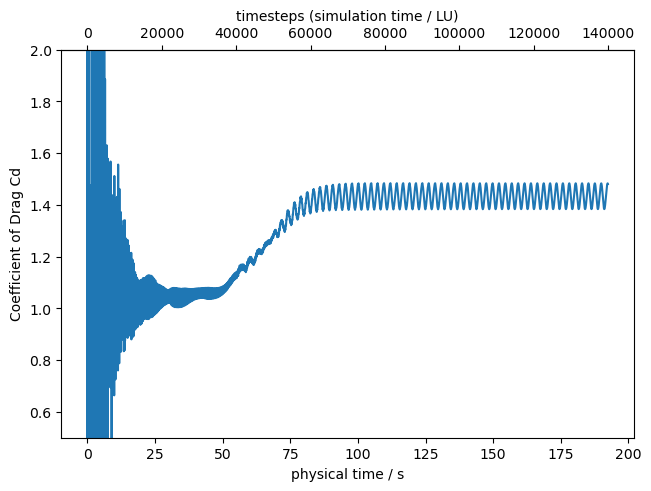

In [15]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,2.0])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")
plt.show()

simple mean:      1.433813493137756
peak_finder mean: 1.4329323471970592
start time of 'mean'-ing: 173.20370611338967


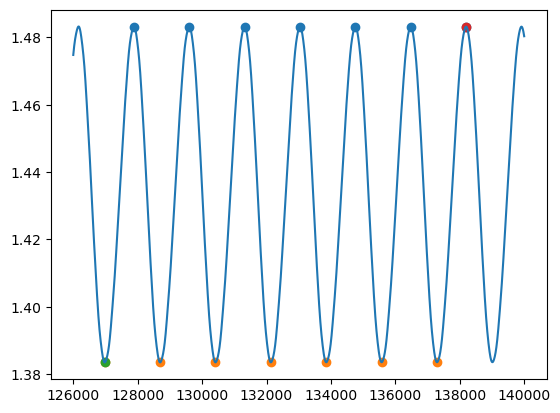

In [16]:
### calculate mean drag_coefficient in periodic region:
try:
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]

    peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
    peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))
    # find peaks only works correctly, if simulation is converged in the periodic region...

    if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
        peak_number = peaks_max[0].shape[0]
    else:
        peak_number = peaks_min[0].shape[0]

    if peaks_min[0][0] < peaks_max[0][0]:
        first_peak = peaks_min[0][0]
        last_peak = peaks_max[0][peak_number-1]
    else:
        first_peak = peaks_max[0][0]
        last_peak = peaks_min[0][peak_number-1]

    drag_mean = values[first_peak:last_peak].mean()
    drag_mean_simple = values.mean()

    print("simple mean:     ",drag_mean_simple)
    print("peak_finder mean:",drag_mean)
    print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1])
    ## plotting peaks from peak_finder:
    drag_stepsLU = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,0]
    peak_max_y = values[peaks_max[0]]
    peak_max_x = drag_stepsLU[peaks_max[0]]
    peak_min_y = values[peaks_min[0]]
    peak_min_x = drag_stepsLU[peaks_min[0]]

    plt.plot(drag_stepsLU, values)
    plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number])
    plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number])
    plt.scatter(drag_stepsLU[first_peak],values[first_peak])
    plt.scatter(drag_stepsLU[last_peak],values[last_peak])
    plt.savefig(output_path+dir_name+"/drag_coefficient_peakfinder.png")
    peakfinder=True
except:
    print("peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)")
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]
    drag_mean_simple = values.mean()
    peakfinder=False
    print("Cd, simple mean:",drag_mean_simple)

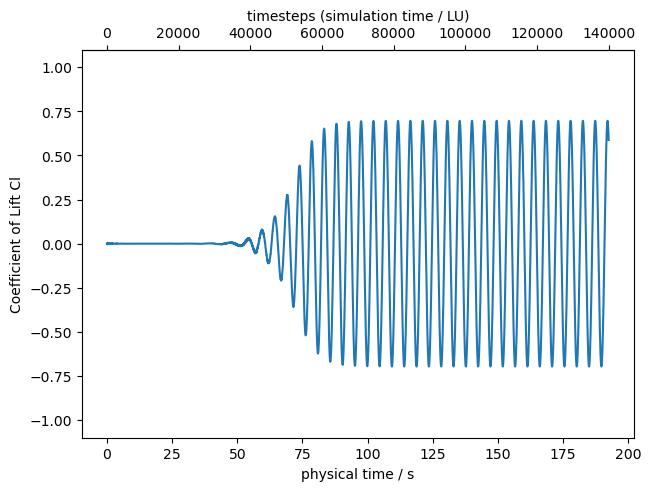

Cl_peaks: 
min -0.6965145093461271 
max 0.6965064419805859


In [17]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1.1,1.1])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

Cl_min = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].min()
Cl_max = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].max()

print("Cl_peaks: \nmin", Cl_min,"\nmax", Cl_max)

Frequency Peak: 0.21304072761148893 +- 0.005196115307597291 Hz


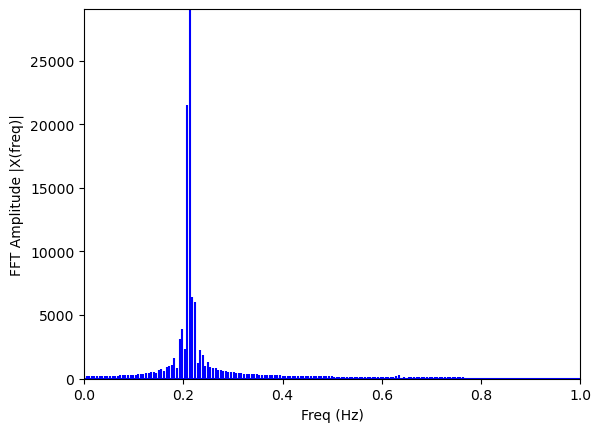

In [18]:
### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

X = np.fft.fft(lift_coefficient[:,2])   # fft result (amplitudes)
N = len(X)  # number of freqs
n = np.arange(N)   # freq index
T = N*flow.units.convert_time_to_pu(1)   # total time measured (T_PU)
freq = n/T   # frequencies (x-axis of spectrum)

plt.figure
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")   # plot spectrum |X|(f)
plt.xlabel("Freq (Hz)")
plt.ylabel("FFT Amplitude |X(freq)|")
plt.xlim(0,1)
#print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum

if output_data:
    plt.savefig(output_path+dir_name+"/fft_Cl.png")

freq_res = freq[1]-freq[0]   # frequency-resolution
X_abs = np.abs(X[:int(X.shape[0]*0.4)])   # get |X| Amplitude for left half of full spectrum
freq_peak = freq[np.argmax(X_abs)]    # find frequency with highest amplitude
print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
# f = Strouhal for St=f*D/U and D=U=1 in PU

In [19]:
# output data
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nMa = "+str(Ma))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nsetup_diameter (D_PU) = "+str(setup_diameter))
    output_file.write("\nflow_velocity (U_PU) = "+str(flow_velocity))
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\ndomain_width_in_D (D/Y) = "+str(domain_width_in_D))
    output_file.write("\ndomain_length_in_D (D/X) = "+str(domain_length_in_D))
    output_file.write("\n")
    output_file.write("\nu_init = "+str(u_init))
    output_file.write("\nperturb_init = "+str(perturb_init))
    output_file.write("\nbb_wall = "+str(bb_wall))
    #output_file.write("\nhwbb BC = "+str(halfway))
    output_file.write("\nvtk_fps = "+str(vtk_fps))
    output_file.write("\nvtk_out = "+str(output_vtk))
    output_file.write("\n")
    output_file.write("\nshape_LU: "+ str(flow.shape[0]) + " x " + str(flow.shape[1]))
    output_file.write("\ntotal No. of gridpoints: "+ str(gridpoints))
    output_file.write("\n")
    output_file.write("output_dir: "+str(output_path+dir_name))
    output_file.write("\n")
    output_file.write("\n###################\n\ncylinder:")
    output_file.write("\nradius_LU = "+str(radius_LU))
    output_file.write("\nx_pos_LU = "+str(x_pos_LU))
    output_file.write("\ny_pos_LU = "+str(y_pos_LU))
    output_file.write("\ntau = "+str(tau))
    output_file.write("\n")
    output_file.write("\n###################\n\nSTATS:")
    output_file.write("\nT_PU = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\n###################\n\nOBSERVABLES:")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(Cl_min))
    output_file.write("\nCl_max = "+str(Cl_max))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nf +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.close()


In [20]:
if output_data:
    print(torch.cuda.memory_summary(device="cuda:0"))

### list present torch tensors:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt", "a")
    total_bytes = 0
    import gc
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
                output_file.write("\n"+str(obj.size())+", "+str(obj.nelement()*obj.element_size()))
                total_bytes = total_bytes+obj.nelement()*obj.element_size()
        except:
            pass
    output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

### count occurence of tensors in list of tensors:
    from collections import Counter
    my_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt","r")
    data=my_file.read()
    my_file.close()
    data_into_list=data.split("\n")
    c = Counter(data_into_list)
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_counted_tensors.txt", "a")
    for k,v in c.items():
        output_file.write("type,size,bytes: {}, number: {}\n".format(k,v) )
    output_file.write("\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    8522 KB |   33522 KB |   22032 GB |   22032 GB |
|       from large pool |    6875 KB |   30625 KB |   19120 GB |   19120 GB |
|       from small pool |    1647 KB |    4147 KB |    2911 GB |    2911 GB |
|---------------------------------------------------------------------------|
| Active memory         |    8522 KB |   33522 KB |   22032 GB |   22032 GB |
|       from large pool |    6875 KB |   30625 KB |   19120 GB |

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [24]:
flow.boundaries[-1].force_sum

tensor([0., 0.], device='cuda:0', dtype=torch.float64)